<a href="https://colab.research.google.com/github/comchem/Pytorch_DeepLearning_Tutorials/blob/master/Sec8-Recommender_Systems/2-Recommender_20M_Modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The modified version is:
* Faster
* Finds a better answer

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

In [2]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2021-04-24 08:55:53--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M   100MB/s    in 1.9s    

2021-04-24 08:55:55 (100 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [3]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [4]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes                # new_user_id = userId - 1

In [6]:
df.tail()

,userId,movieId,rating,timestamp,new_user_id
20000258,138493,68954,4.5,1258126920,138492
20000259,138493,69526,4.5,1259865108,138492
20000260,138493,69644,3.0,1260209457,138492
20000261,138493,70286,5.0,1258126944,138492
20000262,138493,71619,2.5,1255811136,138492


In [7]:
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes    # coded new_movie_id by order start from zero

In [8]:
df.head()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
0,1,2,3.5,1112486027,0,1
1,1,29,3.5,1112484676,0,28
2,1,32,3.5,1112484819,0,31
3,1,47,3.5,1112484727,0,46
4,1,50,3.5,1112484580,0,49


In [9]:
# Get user IDs, movie IDs and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5     # Scaling of rating

In [10]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimemsion
D = 10

In [11]:
print('total # user_ids:', len(user_ids), ', unique # user_ids: ', len(set(user_ids)))

total # user_ids: 20000263 , unique # user_ids:  138493


In [12]:
# Make a neural network
class Model(nn.Module):
  def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
    super(Model, self).__init__()
    self.N = n_users
    self.M = n_items
    self.D = embed_dim

    self.u_emb = nn.Embedding(self.N, self.D)
    self.m_emb = nn.Embedding(self.M, self.D)
    self.fc1 = nn.Linear(2*self.D, n_hidden)
    self.fc2 = nn.Linear(n_hidden, 1)

    # set the weights since N(0,1) leads to poor results      
    # Manually hyperparameter initialization with weights
    self.u_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
    self.m_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.M, self.D) * 0.01))

  def forward(self, u, m):
    u = self.u_emb(u)  # output is (num_samples, D)
    m = self.m_emb(m)  # output is (num_samples, D)

    # merge
    out = torch.cat((u,m),1)   # output is (num_samples, 2D)

    # ANN
    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

In [21]:
# A function to encapsulate the training loop
def batch_gd2(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
  train_users, train_movies, train_ratings = train_data
  test_users, test_movies, test_ratings = test_data

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  # batches per epoch
  Ntrain = len(train_users)
  batches_per_epoch = int(np.ceil(Ntrain/bs))

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []

    # shuffle each batch
    train_users, train_movies, train_ratings = shuffle(
        train_users, train_movies, train_ratings
    )

    for j in range(batches_per_epoch):
      # get the batch
      users = train_users[j*bs:(j+1)*bs]
      movies = train_movies[j*bs:(j+1)*bs]
      targets = train_ratings[j*bs:(j+1)*bs]

      # convert to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)

      # reshape targets
      targets = targets.view(-1, 1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)
      
      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(users, movies)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      
    # Get train loss and test loss
    train_loss = np.mean(train_loss)   # a little misleading

    # we could do this if the test set size was manageable
    # test_outputs = model(test_users, test_movies)
    # test_loss = criterion(test_outputs, test_ratings).item()
    test_loss = []
    for j in range(int(np.ceil(len(test_users) / bs))):
      # get the batch
      users = test_users[j*bs:(j+1)*bs]
      movies = test_movies[j*bs:(j+1)*bs]
      targets = test_ratings[j*bs:(j+1)*bs]

      # convert to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)

      # reshape targets
      targets = targets.view(-1,1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)
      
      outputs = model(users, movies)
      loss = criterion(outputs, targets).item()
      test_loss.append(loss)
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0      
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [22]:
# shuffle the data in corresponding order
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [23]:
# Make datasets
Ntrain = int(0.8 * len(ratings))
train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

train_losses, test_losses = batch_gd2(
    model,
    criterion,
    optimizer,
    (train_users, train_movies, train_ratings),
    (test_users, test_movies, test_ratings),
    10)

Epoch 1/10, Train Loss: 0.6073, Test Loss: 0.6075, Duration: 0:00:55.652027
Epoch 2/10, Train Loss: 0.5823, Test Loss: 0.6108, Duration: 0:00:55.768916
Epoch 3/10, Train Loss: 0.5710, Test Loss: 0.6125, Duration: 0:00:55.237068
Epoch 4/10, Train Loss: 0.5639, Test Loss: 0.6135, Duration: 0:00:55.175035
Epoch 5/10, Train Loss: 0.5587, Test Loss: 0.6152, Duration: 0:00:55.135281
Epoch 6/10, Train Loss: 0.5547, Test Loss: 0.6168, Duration: 0:00:55.000026
Epoch 7/10, Train Loss: 0.5515, Test Loss: 0.6189, Duration: 0:00:55.416122
Epoch 8/10, Train Loss: 0.5488, Test Loss: 0.6195, Duration: 0:00:56.204359
Epoch 9/10, Train Loss: 0.5465, Test Loss: 0.6195, Duration: 0:00:55.248845
Epoch 10/10, Train Loss: 0.5445, Test Loss: 0.6211, Duration: 0:00:55.001991


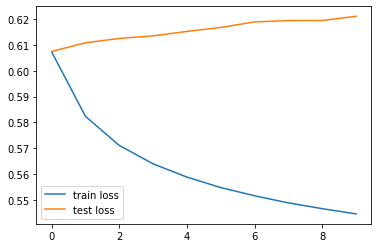

In [24]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()